# National mRS distributions

In [1]:
dir_output = 'output'
limit_to_england = False

## Import packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import stroke_outcome.outcome_utilities

pd.set_option('display.max_rows', 150)

In [3]:
stroke_outcome.__version__

'0.1.6'

## Load data

Results from outcome model:

In [4]:
df_mrs_national_cumsum = pd.read_csv(os.path.join(dir_output, 'cohort_mrs_dists_weighted_national.csv'), index_col=0)

In [6]:
df_mrs_national_cumsum

,mRS<=0,mRS<=1,mRS<=2,mRS<=3,mRS<=4,mRS<=5,mRS<=6
drip_ship_lvo_ivt,0.103557,0.195440,0.327880,0.490122,0.708571,0.823157,1.0
drip_ship_lvo_ivt_mt,0.114716,0.226046,0.371755,0.544526,0.750471,0.850836,1.0
drip_ship_lvo_mix,0.113820,0.223652,0.368348,0.540313,0.747230,0.848694,1.0
drip_ship_lvo_mt,0.114492,0.225885,0.371704,0.544547,0.750516,0.850856,1.0
drip_ship_nlvo_ivt,0.361342,0.589055,0.705083,0.824155,0.921227,0.955152,1.0
drip_ship_weighted,0.182500,0.390153,0.515474,0.653992,0.819884,0.895748,1.0
drip_ship_weighted_treated,0.236545,0.404824,0.535306,0.681046,0.833500,0.901477,1.0
mothership_lvo_ivt,0.097051,0.188086,0.321012,0.483293,0.703836,0.819824,1.0
mothership_lvo_ivt_mt,0.155232,0.276704,0.420797,0.593779,0.783268,0.872474,1.0
mothership_lvo_mix,0.150723,0.269837,0.413064,0.585218,0.777112,0.868394,1.0


In [7]:
df_mrs_national_noncum = pd.read_csv(os.path.join(dir_output, 'cohort_mrs_dists_weighted_national_noncum.csv'), index_col=0)

In [8]:
df_mrs_national_noncum

,mRS=0,mRS=1,mRS=2,mRS=3,mRS=4,mRS=5,mRS=6
drip_ship_lvo_ivt,0.103557,0.091883,0.132440,0.162241,0.218449,0.114585,0.176843
drip_ship_lvo_ivt_mt,0.114716,0.111330,0.145709,0.172771,0.205944,0.100365,0.149164
drip_ship_lvo_mix,0.113820,0.109832,0.144696,0.171965,0.206917,0.101464,0.151306
drip_ship_lvo_mt,0.114492,0.111393,0.145819,0.172843,0.205969,0.100340,0.149144
drip_ship_nlvo_ivt,0.361342,0.227713,0.116027,0.119072,0.097072,0.033926,0.044848
drip_ship_weighted,0.182500,0.207653,0.125321,0.138518,0.165893,0.075864,0.104252
drip_ship_weighted_treated,0.236545,0.168279,0.130482,0.145740,0.152454,0.067977,0.098523
mothership_lvo_ivt,0.097051,0.091035,0.132926,0.162281,0.220543,0.115988,0.180176
mothership_lvo_ivt_mt,0.155232,0.121472,0.144093,0.172983,0.189488,0.089206,0.127526
mothership_lvo_mix,0.150723,0.119113,0.143227,0.172153,0.191895,0.091282,0.131606


In [9]:
df_mrs_national_std = pd.read_csv(os.path.join(dir_output, 'cohort_mrs_dists_weighted_national_std.csv'), index_col=0)

In [10]:
df_mrs_national_std

,mRS=0,mRS=1,mRS=2,mRS=3,mRS=4,mRS=5,mRS=6
drip_ship_lvo_ivt,0.002619,0.000293,0.000223,0.000032,0.000826,0.000546,0.001285
drip_ship_lvo_ivt_mt,0.009830,0.003991,0.001429,0.001293,0.004516,0.003555,0.007289
drip_ship_lvo_mix,0.007843,0.003172,0.001123,0.001020,0.003598,0.002829,0.005803
drip_ship_lvo_mt,0.010367,0.003729,0.000536,0.000805,0.004602,0.003466,0.007233
drip_ship_nlvo_ivt,0.006673,0.002145,0.000390,0.000636,0.001602,0.000744,0.001157
drip_ship_weighted,0.001283,0.000478,0.000149,0.000150,0.000493,0.000367,0.000742
drip_ship_weighted_treated,0.005156,0.001921,0.000598,0.000603,0.001980,0.001473,0.002982
mothership_lvo_ivt,0.005683,0.000897,0.000350,0.000044,0.001879,0.001281,0.003087
mothership_lvo_ivt_mt,0.012266,0.002498,0.000931,0.000322,0.004746,0.003068,0.005774
mothership_lvo_mix,0.009777,0.001990,0.000742,0.000256,0.003782,0.002445,0.004604


In [11]:
cols_each_scen = df_mrs_national_noncum.index.values

cols_each_scen

array(['drip_ship_lvo_ivt', 'drip_ship_lvo_ivt_mt', 'drip_ship_lvo_mix',
       'drip_ship_lvo_mt', 'drip_ship_nlvo_ivt', 'drip_ship_weighted',
       'drip_ship_weighted_treated', 'mothership_lvo_ivt',
       'mothership_lvo_ivt_mt', 'mothership_lvo_mix', 'mothership_lvo_mt',
       'mothership_nlvo_ivt', 'mothership_weighted',
       'mothership_weighted_treated'], dtype=object)

Reference no-treatment mRS distributions:

In [12]:
mrs_dists, mrs_dists_notes = (
    stroke_outcome.outcome_utilities.import_mrs_dists_from_file())

In [13]:
mrs_dists

,mRS<=0,mRS<=1,mRS<=2,mRS<=3,mRS<=4,mRS<=5,mRS<=6
Stroke type,,,,,,,
pre_stroke_nlvo,0.583,0.746,0.850,0.951,0.993,1.000,1
pre_stroke_lvo,0.408,0.552,0.672,0.838,0.956,1.000,1
no_treatment_lvo,0.050,0.129,0.265,0.429,0.676,0.811,1
no_treatment_nlvo,0.198,0.460,0.580,0.708,0.856,0.918,1
no_effect_nlvo_ivt_deaths,0.196,0.455,0.574,0.701,0.847,0.908,1
no_effect_lvo_ivt_deaths,0.048,0.124,0.255,0.414,0.653,0.783,1
no_effect_lvo_mt_deaths,0.048,0.124,0.255,0.412,0.649,0.779,1
t0_treatment_nlvo_ivt,0.445,0.642,0.752,0.862,0.941,0.967,1
t0_treatment_lvo_ivt,0.140,0.233,0.361,0.522,0.730,0.838,1


In [14]:
mrs_dist_nlvo_no_treatment = mrs_dists.loc['no_treatment_nlvo'].values
mrs_dist_lvo_no_treatment = mrs_dists.loc['no_treatment_lvo'].values

mrs_dist_nlvo_no_treatment_noncum = np.diff(mrs_dist_nlvo_no_treatment, prepend=0.0)
mrs_dist_lvo_no_treatment_noncum = np.diff(mrs_dist_lvo_no_treatment, prepend=0.0)

Stroke type proportions:

In [15]:
proportions = pd.read_csv(
    os.path.join(dir_output, 'patient_proportions.csv'),
    index_col=0, header=None).squeeze()

In [16]:
proportions

0
haemorrhagic         0.13600
lvo_no_treatment     0.14648
lvo_ivt_only         0.00840
lvo_ivt_mt           0.08500
lvo_mt_only          0.01500
nlvo_no_treatment    0.50252
nlvo_ivt             0.10660
Name: 1, dtype: float64

### Calculate weighted no treatment dist:

In [17]:
prop_lvo = 0.0
prop_nlvo = 0.0

for key, value in proportions.items():
    if 'nlvo' in key:
        prop_nlvo += value
    elif 'lvo' in key:
        prop_lvo += value

In [18]:
prop_lvo, prop_nlvo

(0.25488, 0.60912)

In [19]:
prop_lvo / (prop_nlvo + prop_lvo), prop_nlvo / (prop_nlvo + prop_lvo)

(0.295, 0.705)

In [20]:
mrs_dist_weighted_no_treatment_noncum = (
    (mrs_dist_nlvo_no_treatment_noncum * prop_nlvo) +
    (mrs_dist_lvo_no_treatment_noncum * prop_lvo)
)

# Remove the non-ischaemic patients:
mrs_dist_weighted_no_treatment_noncum = (
    mrs_dist_weighted_no_treatment_noncum / (prop_nlvo + prop_lvo)
)

In [21]:
np.sum(mrs_dist_weighted_no_treatment_noncum)

0.9999999999999999

In [30]:
# Same structure as the other distribution dictionaries:
dict_no_treat = {
    'nlvo': {
        'values': mrs_dist_nlvo_no_treatment_noncum,
        'cumsum': np.cumsum(mrs_dist_nlvo_no_treatment_noncum)
    },
    'lvo': {
        'values': mrs_dist_lvo_no_treatment_noncum,
        'cumsum': np.cumsum(mrs_dist_lvo_no_treatment_noncum)
    },
    'weighted': {
        'values': mrs_dist_weighted_no_treatment_noncum,
        'cumsum': np.cumsum(mrs_dist_weighted_no_treatment_noncum)
    },
    'weighted_treated': {
        'values': mrs_dist_weighted_no_treatment_noncum,
        'cumsum': np.cumsum(mrs_dist_weighted_no_treatment_noncum)
    },
}

## Gather data for plots

In [31]:
def gather_dists(scenario, df_mrs_national_noncum, df_mrs_national_std, df_mrs_national_cumsum):
    d = {}

    for cohort in ['nlvo_ivt', 'lvo_mix', 'weighted', 'weighted_treated']:
        ind = f'{scenario}_{cohort}'

        d[cohort] = {}
        d[cohort]['values'] = df_mrs_national_noncum.loc[ind]
        d[cohort]['std'] = df_mrs_national_std.loc[ind]
        d[cohort]['cumsum'] = df_mrs_national_cumsum.loc[ind]
    
    return d

In [26]:
dict_drip_ship = gather_dists('drip_ship', df_mrs_national_noncum, df_mrs_national_std, df_mrs_national_cumsum)
dict_mothership = gather_dists('mothership', df_mrs_national_noncum, df_mrs_national_std, df_mrs_national_cumsum)

## Plot

In [27]:
colour_drip = '#00517f'   # seaborn colorblind blue darker
colour_moth = '#0072b2'  # seaborn colorblind blue
colour_no_treat = 'DarkGray'

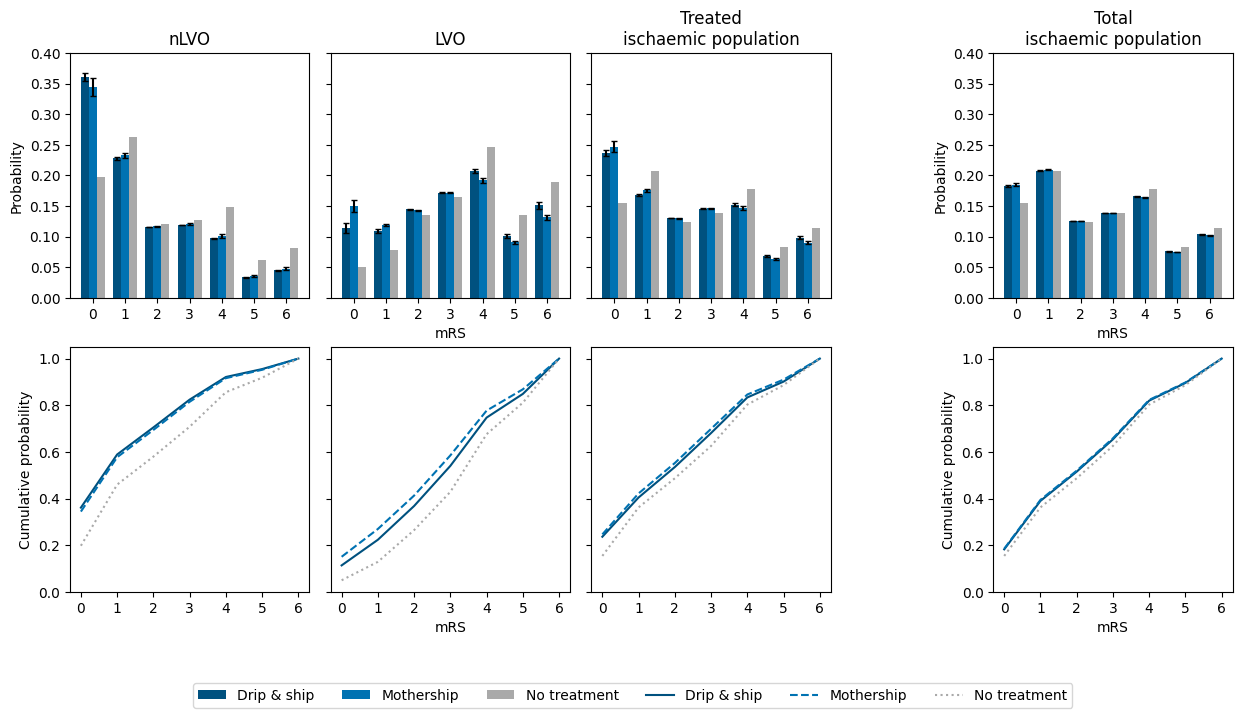

In [42]:
fig, axs = plt.subplots(2, 5, figsize=(15, 7), gridspec_kw={'wspace': 0.1, 'width_ratios':[1, 1, 1, 0.5, 1]})

bar_width = 0.25
offsets = [-bar_width, 0.0, bar_width]

legend_drawn = False
for c, cohort in enumerate(['nlvo_ivt', 'lvo_mix', 'weighted', 'weighted_treated']):
    dist_drip = dict_drip_ship[cohort]['values']
    std_drip = dict_drip_ship[cohort]['std']
    dist_cumsum_drip = dict_drip_ship[cohort]['cumsum']
    dist_moth = dict_mothership[cohort]['values']
    std_moth = dict_mothership[cohort]['std']
    dist_cumsum_moth = dict_mothership[cohort]['cumsum']
    
    if 'nlvo' in cohort:
        ax = axs[0, 0]
        ax_cumsum = axs[1, 0]
        dist_no_treat = dict_no_treat['nlvo']['values']
        dist_cumsum_no_treat = dict_no_treat['nlvo']['cumsum']
    elif 'lvo' in cohort:
        ax = axs[0, 1]
        ax_cumsum = axs[1, 1]
        dist_no_treat = dict_no_treat['lvo']['values']
        dist_cumsum_no_treat = dict_no_treat['lvo']['cumsum']
    elif 'treated' in cohort:
        ax = axs[0, 2]
        ax_cumsum = axs[1, 2]
        dist_no_treat = dict_no_treat['weighted_treated']['values']
        dist_cumsum_no_treat = dict_no_treat['weighted_treated']['cumsum']
    else:
        ax = axs[0, -1]
        ax_cumsum = axs[1, -1]
        dist_no_treat = dict_no_treat['weighted']['values']
        dist_cumsum_no_treat = dict_no_treat['weighted']['cumsum']

    ax.bar(
        np.arange(7) + offsets[0], dist_drip, yerr=std_drip, capsize=2.0,
        facecolor=colour_drip, label='Drip & ship', width=bar_width
        )
    ax.bar(
        np.arange(7) + offsets[1], dist_moth, yerr=std_moth, capsize=2.0,
        facecolor=colour_moth, label='Mothership', width=bar_width
        )
    ax.bar(
        np.arange(7) + offsets[2], dist_no_treat,
        facecolor=colour_no_treat, label='No treatment', width=bar_width
        )

    ax_cumsum.plot(np.arange(7), dist_cumsum_drip, color=colour_drip, linestyle='-', label='Drip & ship')
    ax_cumsum.plot(np.arange(7), dist_cumsum_moth, color=colour_moth, linestyle='--', label='Mothership')
    ax_cumsum.plot(np.arange(7), dist_cumsum_no_treat, color=colour_no_treat, linestyle=':', label='No treatment')

    if legend_drawn is False:
        fig.legend(bbox_to_anchor=(0.5, -0.01), loc='upper center', ncol=6)
        legend_drawn = True

for i, ax_list in enumerate(axs):
    ylim = [0, 0.4] if i == 0 else [0.0, 1.05]
    for j, ax in enumerate(ax_list):
        ax.set_ylim(*ylim)
        ax.set_xticks(range(7))
        if (j > 0) & (j < len(ax_list) - 1):
            ax.set_yticklabels([])

axs[0, 0].set_title('nLVO')
axs[0, 1].set_title('LVO')
axs[0, 2].set_title('Treated\nischaemic population')
axs[0, -1].set_title('Total\nischaemic population')

axs[0, 0].set_ylabel('Probability')
axs[0, -1].set_ylabel('Probability')
axs[0, -1].yaxis.set_tick_params(labelleft=True)  # turn the tick labels back on
axs[0, 1].set_xlabel('mRS')
axs[0, -1].set_xlabel('mRS')

axs[1, 0].set_ylabel('Cumulative probability')
axs[1, -1].set_ylabel('Cumulative probability')
axs[1, -1].yaxis.set_tick_params(labelleft=True)  # turn the tick labels back on
axs[1, 1].set_xlabel('mRS')
axs[1, -1].set_xlabel('mRS')

axs[0, 3].axis('off')
axs[1, 3].axis('off')

plt.savefig(os.path.join(dir_output, 'mrs_dists_redirection_areas.png'), bbox_inches='tight')
plt.show()

## Find mean values

Import utility scores

In [43]:
utility_dists, utility_dists_notes = (
    stroke_outcome.outcome_utilities.import_utility_dists_from_file())

utility_weights = utility_dists.loc['Wang2020'].values

In [44]:
dist_dicts = {
    'drip_ship': dict_drip_ship,
    'mothership': dict_mothership,
    'no_treat': dict_no_treat
}

In [45]:
df_means = pd.DataFrame()

for scenario, dist_dict in dist_dicts.items():
    for cohort, d_dict in dist_dict.items():
            
        if 'nlvo' in cohort:
            dist_no_treat = dict_no_treat['nlvo']['values']
        elif 'lvo' in cohort:
            dist_no_treat = dict_no_treat['lvo']['values']
        elif 'treated' in cohort:
            dist_no_treat = dict_no_treat['weighted_treated']['values']
        else:
            dist_no_treat = dict_no_treat['weighted']['values']

        mean_mrs_no_treat = np.mean(dist_no_treat * np.arange(7))
        mean_util_no_treat = np.mean(dist_no_treat * utility_weights)
        mrsleq2_no_treat = np.sum(dist_no_treat[:3])
            
        dist = d_dict['values']
        ind = f'{scenario}_{cohort}'
        df_means.loc[ind, 'mean_mrs'] = np.mean(dist * np.arange(7))
        df_means.loc[ind, 'mean_util'] = np.mean(dist * utility_weights)
        df_means.loc[ind, 'mrsleq2'] = np.sum(dist[:3])
        df_means.loc[ind, 'mean_mrs_shift'] = (
            df_means.loc[ind, 'mean_mrs'] - mean_mrs_no_treat)
        df_means.loc[ind, 'mean_util_shift'] = (
            df_means.loc[ind, 'mean_util'] - mean_util_no_treat)
        df_means.loc[ind, 'mrsleq2_shift'] = (
            df_means.loc[ind, 'mrsleq2'] - mrsleq2_no_treat)

In [46]:
df_means

,mean_mrs,mean_util,mrsleq2,mean_mrs_shift,mean_util_shift,mrsleq2_shift
drip_ship_nlvo_ivt,0.234855,0.102173,0.705083,-0.090859,0.016510,0.125083
drip_ship_lvo_mix,0.451135,0.061546,0.368348,-0.068865,0.014030,0.103348
drip_ship_weighted,0.363178,0.078207,0.515474,-0.019850,0.003797,0.028399
drip_ship_weighted_treated,0.343900,0.081689,0.535306,-0.039128,0.007280,0.048231
mothership_nlvo_ivt,0.242963,0.100770,0.694312,-0.082752,0.015107,0.114312
mothership_lvo_mix,0.419379,0.067533,0.413064,-0.100621,0.020017,0.148064
mothership_weighted,0.360194,0.078785,0.519755,-0.022834,0.004375,0.032680
mothership_weighted_treated,0.331909,0.084012,0.552511,-0.051119,0.009603,0.065436
no_treat_nlvo,0.325714,0.085663,0.580000,0.000000,0.000000,0.000000
no_treat_lvo,0.520000,0.047516,0.265000,0.000000,0.000000,0.000000


### Save a copy of data behind the figure

Keep a copy of the separate LVO cohorts even though the figure only shows the combined LVO cohort.

Add the no-treatment distributions into the starting data:

In [47]:
for key, value in dict_no_treat.items():
    ind = f'no_treatment_{key}'
    df_mrs_national_noncum.loc[ind] = value
    df_mrs_national_std.loc[ind] = pd.NA

In [48]:
# Save to file:
df_mrs_national_noncum.to_csv(os.path.join(dir_output, 'fig_data_mrs_dists.csv'))
df_mrs_national_std.to_csv(os.path.join(dir_output, 'fig_data_mrs_dists_std.csv'))

In [49]:
df_means.to_csv(os.path.join(dir_output, 'fig_data_mrs_dists_means.csv'))